In [1]:
%store -r

In [2]:
import os
import pathlib
from glob import glob

from math import floor, ceil

import earthaccess
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import rioxarray as rxr
import rioxarray.merge as rxrmerge
import xarray as xr
import xrspatial

c:\Users\tjsto\miniconda3\envs\earth-analytics-python\Lib\site-packages\dask\dataframe\__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


# Elevation Data
Elevation from the SRTM (available from the earthaccess API)

In [3]:
earthaccess.login()

In [4]:
# Search earthaccess for a suitable dataset
datasets = earthaccess.search_datasets(keyword='SRTMGL1')
for dataset in datasets:
    print(dataset['umm']['ShortName'], dataset['umm']['EntryTitle'])


SRTMGL1 NASA Shuttle Radar Topography Mission Global 1 arc second V003
SRTMGL3 NASA Shuttle Radar Topography Mission Global 3 arc second V003
SRTMGL1_NC NASA Shuttle Radar Topography Mission Global 1 arc second NetCDF V003
SRTMGL1N NASA Shuttle Radar Topography Mission Global 1 arc second number V003
SRTMGL1_NUMNC NASA Shuttle Radar Topography Mission Global 1 arc second Number NetCDF V003
SRTMGL3S NASA Shuttle Radar Topography Mission Global 3 arc second sub-sampled V003


In [5]:
def set_buffer(boundary_gdf, buffer=0):
    """
    Increases the max bounds of a geo data frame by a set amount.
    Returns the max bounds as a tuple.
    """
    bounds = tuple(boundary_gdf.total_bounds)
    xmin, ymin, xmax, ymax = bounds
    bounds_buffer = (xmin-buffer, ymin-buffer, xmax+buffer, ymax+buffer)

    return bounds_buffer

In [6]:
def srtm_data_download(boundary_gdf, buffer=0.025):
    elevation_dir = os.path.join(data_dir, 
                                  'srtm',
                                  boundary_gdf.FORESTNAME.values[0])
    os.makedirs(elevation_dir, exist_ok=True)

    srtm_pattern = os.path.join(elevation_dir, '*.hgt.zip')

    bounds_buffer = set_buffer(boundary_gdf, buffer)

    if not glob(srtm_pattern):
        srtm_results = earthaccess.search_data(
            short_name='SRTMGL1',
            bounding_box=bounds_buffer
        )
        srtm_results = earthaccess.download(srtm_results, elevation_dir)
    
    srtm_da_list = []

    for srtm_path in glob(srtm_pattern):
        tile_da = rxr.open_rasterio(srtm_path, mask_and_scale=True).squeeze()
        cropped_da = tile_da.rio.clip_box(*bounds_buffer)
        srtm_da_list.append(cropped_da)
    
    srtm_da =rxrmerge.merge_arrays(srtm_da_list)

    return srtm_da

In [7]:
elevation_das = []

for site in site_list:
    elevation_da = srtm_data_download(site)
    elevation_das.append(dict(
        site_name=site.FORESTNAME.values[0],
        elevation_da=elevation_da
    ))
topo_df = pd.DataFrame(elevation_das)

<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='x', ylabel='y'>

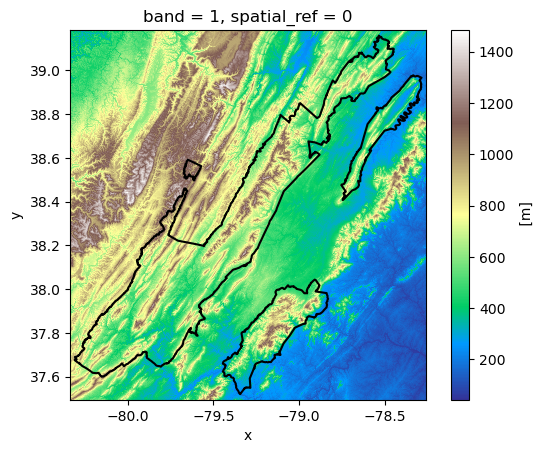

In [9]:
topo_df.elevation_da[0].plot(cmap='terrain')
site_list[0].boundary.plot(ax=plt.gca(), color='black')

<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='x', ylabel='y'>

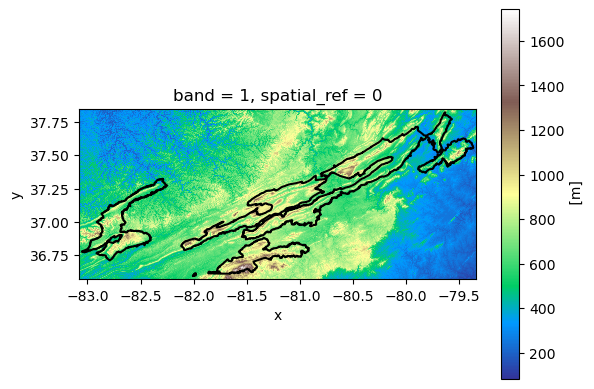

In [10]:
topo_df.elevation_da[1].plot(cmap='terrain')
site_list[1].boundary.plot(ax=plt.gca(), color='black')

# Derived Slope Variable
Calculate at least one derived topographic variable (slope or aspect) to use in your model. You probably will wish to use the xarray-spatial library, which is available in the latest earth-analytics-python environment (but will need to be installed/updated if you are working on your own machine). Note that calculated slope may not be correct if you are using a CRS with units of degrees; you should re-project into a projected coordinate system with units of meters, such as the appropriate UTM Zone.

In [11]:
def derive_slope(site_gdf, elevation_da):
    # Estimate the UTM CRS based on the bounds of the site
    epsg_utm = site_gdf.estimate_utm_crs()
    # Reproject boundary and elevation data so that units are in meters
    elevation_proj_da = elevation_da.rio.reproject(epsg_utm)
    site_proj_gdf = site_gdf.to_crs(epsg_utm)
    
    # Calculate slope using xrspatial
    slope_full_da = xrspatial.slope(elevation_proj_da)
    slope_da = slope_full_da.rio.clip(site_proj_gdf.geometry)

    return slope_da

In [18]:
slope_das = []

for (site, elevation_da) in zip(site_list, topo_df.elevation_da):
    slope_da = derive_slope(site, elevation_da)
    slope_da = slope_da.rio.reproject_match(elevation_da)
    slope_das.append(slope_da)

topo_df['slope_da'] = slope_das
topo_df
    

,site_name,elevation_da,slope_da
0,George Washington National Forest,"[[<xarray.DataArray ()> Size: 4B\narray(394., ...",[[<xarray.DataArray 'slope' ()> Size: 4B\narra...
1,Jefferson National Forest,"[[<xarray.DataArray ()> Size: 4B\narray(366., ...",[[<xarray.DataArray 'slope' ()> Size: 4B\narra...


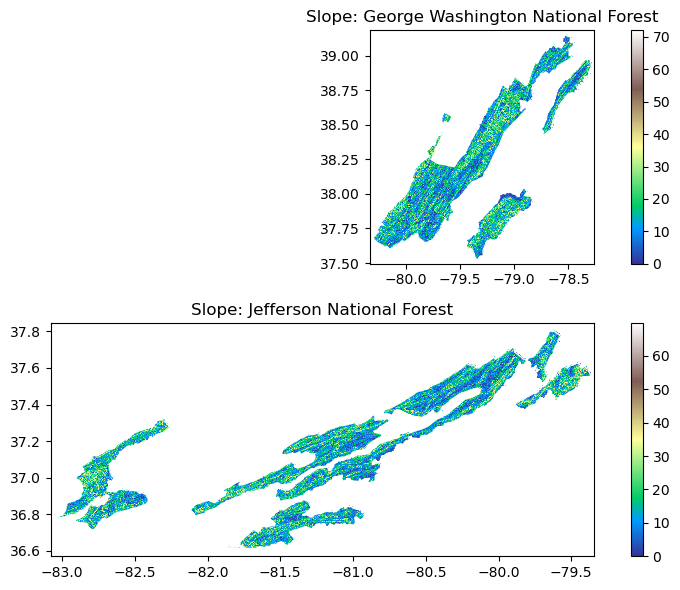

In [15]:
# Visualize the soil data

num_plots = len(topo_df.slope_da)

# Create subplots dynamically based on the number of plots
fig, axes = plt.subplots(num_plots, 1, figsize=(8, 6))

# In case of only one plot
if num_plots == 1:
    axes = [axes]

# Loop over soil DataArrays and site list
for i, (site_da, site) in enumerate(zip(topo_df.slope_da, site_list)):

    # Display raster data
    im = axes[i].imshow(
        site_da.values, 
        cmap='terrain', 
        interpolation='nearest', 
        extent=(
            site_da.x.min(),
            site_da.x.max(),
            site_da.y.min(),
            site_da.y.max()
        ))
    # Set title based on site name
    axes[i].set_title(f"Slope: {site.FORESTNAME.values[0]}")
    # Set site boundary line
    site.boundary.plot(ax=axes[i], color='white', linewidth=1)
    # Set colorbar
    fig.colorbar(im, ax=axes[i])

plt.tight_layout()
plt.show()

In [19]:
%store topo_df

Stored 'topo_df' (DataFrame)


In [20]:
slope_das[0].rio.crs

CRS.from_epsg(4326)